choose miniconda env

In [1]:
! ls raw

diagnosis.csv        medrecon.csv         vitalsign.csv
edstays.csv          pyxis.csv
icd9toicd10cmgem.csv triage.csv


In [238]:
import os 
os.getcwd()
import numpy as np
import sklearn.preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
nlp = spacy.load('en_core_web_sm')
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from scipy import stats

# Clean data
import re

In [3]:
def look_n_load(path):
    df = pd.read_csv(path)
    print('\nShape:', df.shape)
    print('\nColumns:', list(df.columns))
#     print('\n',df.describe())
    print('\nMissing proportions:\n', df.isna().sum()/len(df))
    return df

# 1. Data overview

## 1.1 Diagnostic table

In [4]:
diagnosis = look_n_load('raw/diagnosis.csv')


Shape: (946692, 6)

Columns: ['subject_id', 'stay_id', 'seq_num', 'icd_code', 'icd_version', 'icd_title']

Missing proportions:
 subject_id     0.0
stay_id        0.0
seq_num        0.0
icd_code       0.0
icd_version    0.0
icd_title      0.0
dtype: float64


In [5]:
diagnosis[diagnosis['icd_code'].str.startswith("0")]

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title


In [6]:
icd_conversion = pd.read_csv('raw/icd9toicd10cmgem.csv')

In [7]:
icd_conversion

,icd9cm,icd10cm,flags,approximate,no_map,combination,scenario,choice_list
0,0010,A000,0,0,0,0,0,0
1,0011,A001,0,0,0,0,0,0
2,0019,A009,0,0,0,0,0,0
3,0020,A0100,10000,1,0,0,0,0
4,0021,A011,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
23907,V9129,O30299,10000,1,0,0,0,0
23908,V9190,O30809,10000,1,0,0,0,0
23909,V9191,O30819,10000,1,0,0,0,0
23910,V9192,O30829,10000,1,0,0,0,0


In [8]:
diagnosis_1 = pd.merge(diagnosis,icd_conversion[['icd9cm','icd10cm']],how='left',left_on='icd_code',right_on='icd9cm')

In [9]:
diagnosis_1[(diagnosis_1.icd_version == 9) & (diagnosis_1['icd10cm'].isna())]

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title,icd9cm,icd10cm
1,10000032,32952584,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
6,10000032,33258284,3,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
14,10000032,38112554,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
280,10002157,31887902,1,88,9,VIRAL ENTERITIS NOS,NaN,NaN
467,10002930,31579293,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
...,...,...,...,...,...,...,...,...
1197929,19983860,36599398,3,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN
1197945,19983948,38567517,1,8881,9,LYME DISEASE,NaN,NaN
1198018,19985000,39581850,1,845,9,CLOSTRIDIUM DIFFICILE,NaN,NaN
1198168,19985885,38207246,1,539,9,HERPES ZOSTER NOS,NaN,NaN


In [10]:
diagnosis_1[(diagnosis_1.icd_version == 9) & (diagnosis_1['icd10cm'].isna())].icd_code.value_counts()

7070    1045
389      904
539      302
7054     182
845      131
        ... 
9959       1
85         1
37         1
543        1
794        1
Name: icd_code, Length: 104, dtype: int64

This NA case because some code in Version9 doesn't have exactly same code in Version 10, therefore we keep icd code version 9 for these case

In [11]:
diagnosis_1['fin_code'] = diagnosis_1['icd_code']
diagnosis_1.loc[diagnosis_1.icd_version == 9, 'fin_code'] = diagnosis_1.loc[diagnosis_1.icd_version == 9,'icd10cm']

In [12]:
diagnosis_1.loc[diagnosis_1.fin_code.isna(),'fin_code'] = diagnosis_1.loc[diagnosis_1.fin_code.isna(),'icd_code']

In [13]:
diagnosis_1

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title,icd9cm,icd10cm,fin_code
0,10000032,32952584,1,4589,9,HYPOTENSION NOS,4589,I959,I959
1,10000032,32952584,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN,7070
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION,V08,Z21,Z21
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",5728,K7210,K7210
4,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",5728,K7290,K7290
...,...,...,...,...,...,...,...,...,...
1199788,19999828,30712109,1,K632,10,Fistula of intestine,NaN,NaN,K632
1199789,19999828,32917002,1,E1110,10,Type 2 diabetes mellitus with ketoacidosis wit...,NaN,NaN,E1110
1199790,19999828,32917002,2,Z7984,10,Long term (current) use of oral hypoglycemic d...,NaN,NaN,Z7984
1199791,19999914,32002659,1,R4182,10,"Altered mental status, unspecified",NaN,NaN,R4182


In [14]:
diagnosis_1['fin_code_group'] = diagnosis_1['fin_code'].apply(lambda x: x[:3])

In [15]:
diagnosis_1

,subject_id,stay_id,seq_num,icd_code,icd_version,icd_title,icd9cm,icd10cm,fin_code,fin_code_group
0,10000032,32952584,1,4589,9,HYPOTENSION NOS,4589,I959,I959,I95
1,10000032,32952584,2,7070,9,UNSPECIFIED VIRAL HEPATITIS C WITHOUT HEPATIC ...,NaN,NaN,7070,707
2,10000032,32952584,3,V08,9,ASYMPTOMATIC HIV INFECTION,V08,Z21,Z21,Z21
3,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",5728,K7210,K7210,K72
4,10000032,33258284,1,5728,9,"OTH SEQUELA, CHR LIV DIS",5728,K7290,K7290,K72
...,...,...,...,...,...,...,...,...,...,...
1199788,19999828,30712109,1,K632,10,Fistula of intestine,NaN,NaN,K632,K63
1199789,19999828,32917002,1,E1110,10,Type 2 diabetes mellitus with ketoacidosis wit...,NaN,NaN,E1110,E11
1199790,19999828,32917002,2,Z7984,10,Long term (current) use of oral hypoglycemic d...,NaN,NaN,Z7984,Z79
1199791,19999914,32002659,1,R4182,10,"Altered mental status, unspecified",NaN,NaN,R4182,R41


In [16]:
diagnosis_1['key'] = diagnosis_1['subject_id'].astype(str)+'_'+diagnosis_1['stay_id'].astype(str)

## 1.2 Edstays table

In [18]:
edstays = look_n_load('raw/edstays.csv')


Shape: (447712, 9)

Columns: ['subject_id', 'hadm_id', 'stay_id', 'intime', 'outtime', 'gender', 'race', 'arrival_transport', 'disposition']

Missing proportions:
 subject_id           0.000000
hadm_id              0.522213
stay_id              0.000000
intime               0.000000
outtime              0.000000
gender               0.000000
race                 0.000000
arrival_transport    0.000000
disposition          0.000000
dtype: float64


In [19]:
edstays['disposition'].value_counts()

HOME                           254545
ADMITTED                       166303
TRANSFER                         7436
LEFT WITHOUT BEING SEEN          6516
ELOPED                           6011
OTHER                            4520
LEFT AGAINST MEDICAL ADVICE      1986
EXPIRED                           395
Name: disposition, dtype: int64

array([<AxesSubplot:ylabel='disposition'>], dtype=object)

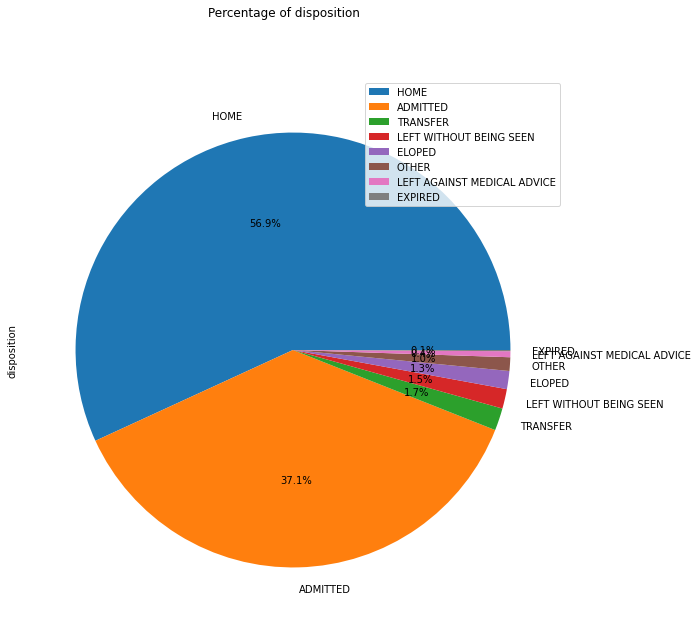

In [20]:
cls_table = pd.DataFrame(edstays['disposition'].value_counts(normalize=True))
cls_table.plot(kind='pie', y = 'disposition',subplots=True, autopct='%1.1f%%', title = "Percentage of disposition", figsize=(10,10))

In [21]:
edstays['y_var_adm_text'] = edstays['disposition']

In [22]:
edstays.loc[edstays['y_var_adm_text'] == 'TRANSFER', 'y_var_adm_text'] = 'ADMITTED'
edstays.loc[edstays['y_var_adm_text'] == 'ELOPED','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT WITHOUT BEING SEEN','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'OTHER','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'LEFT AGAINST MEDICAL ADVICE','y_var_adm_text'] = 'MISSING'
edstays.loc[edstays['y_var_adm_text'] == 'EXPIRED','y_var_adm_text'] = 'MISSING'

In [23]:
edstays_admit = edstays[edstays['y_var_adm_text'] !='MISSING'].reset_index(drop = True)

array([<AxesSubplot:ylabel='y_var_adm_text'>], dtype=object)

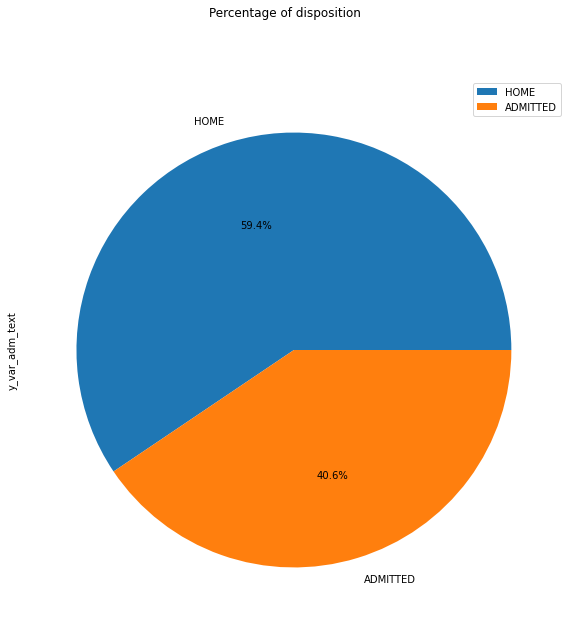

In [24]:
cls_table = pd.DataFrame(edstays_admit['y_var_adm_text'].value_counts(normalize=True))
cls_table.plot(kind='pie', y = 'y_var_adm_text',subplots=True, autopct='%1.1f%%', title = "Percentage of disposition", figsize=(10,10))

In [25]:
edstays_admit['key'] = edstays_admit['subject_id'].astype(str)+'_'+edstays_admit['stay_id'].astype(str)

In [26]:
edstays_admit

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_33258284
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_38112554
2,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_35968195
3,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,HOME,10000032_32952584
4,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_39399961
...,...,...,...,...,...,...,...,...,...,...,...
428279,19999784,25715748.0,34149746,11/8/2119 9:15,11/8/2119 13:40,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_34149746
428280,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_35692999
428281,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,19999828_32917002
428282,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,ADMITTED,19999828_30712109


In [27]:
list_diagnosis_leftjoin_in_edstay = pd.merge(diagnosis_1,edstays_admit,how='left', on = 'key')

In [28]:
list_diagnosis_not_in_edstay = set(list_diagnosis_leftjoin_in_edstay[list_diagnosis_leftjoin_in_edstay['intime'].isna()]['key'].to_list())

In [29]:
len(list_diagnosis_not_in_edstay)

19267

19.267 key in diagostic not in edstay (after remove invalid outcome)

In [30]:
key_diag_df = pd.DataFrame(set(diagnosis_1['key'].to_list()),columns=['key_diag'])

In [31]:
list_diagnosis_rightjoin_in_edstay = pd.merge(key_diag_df,edstays_admit,how='right', left_on='key_diag', right_on='key')

In [32]:
list_edstay_not_in_diagnosis = list_diagnosis_rightjoin_in_edstay[list_diagnosis_rightjoin_in_edstay['key_diag'].isna()]

In [33]:
list_edstay_not_in_diagnosis

,key_diag,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key
288,NaN,10005909,20199380.0,32719751,28/10/2144 18:29,29/10/2144 0:10,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10005909_32719751
343,NaN,10007462,29383640.0,34572020,13/1/2132 15:02,13/1/2132 17:49,M,HISPANIC/LATINO - PUERTO RICAN,WALK IN,ADMITTED,ADMITTED,10007462_34572020
468,NaN,10010655,24811327.0,34867382,28/8/2167 1:00,29/8/2167 19:51,F,BLACK/AFRICAN AMERICAN,AMBULANCE,TRANSFER,ADMITTED,10010655_34867382
1044,NaN,10023349,24313094.0,34494442,16/6/2163 12:06,20/6/2163 15:50,M,HISPANIC/LATINO - CUBAN,AMBULANCE,HOME,HOME,10023349_34494442
1290,NaN,10027100,NaN,36893425,15/8/2156 4:18,15/8/2156 8:09,M,BLACK/AFRICAN AMERICAN,UNKNOWN,HOME,HOME,10027100_36893425
...,...,...,...,...,...,...,...,...,...,...,...,...
425965,NaN,19940888,26227054.0,34464867,25/4/2113 7:58,26/4/2113 19:35,F,WHITE,WALK IN,TRANSFER,ADMITTED,19940888_34464867
427186,NaN,19972235,21800879.0,32088734,26/7/2177 15:43,27/7/2177 7:14,M,WHITE,AMBULANCE,ADMITTED,ADMITTED,19972235_32088734
427472,NaN,19979469,24852288.0,30152667,23/7/2202 12:05,23/7/2202 18:19,M,WHITE,WALK IN,ADMITTED,ADMITTED,19979469_30152667
427919,NaN,19990821,27777812.0,35896332,6/3/2143 15:06,6/3/2143 16:21,M,UNKNOWN,UNKNOWN,ADMITTED,ADMITTED,19990821_35896332


In [34]:
list_edstay_not_in_diagnosis['y_var_adm_text'].value_counts()

ADMITTED    549
HOME        472
Name: y_var_adm_text, dtype: int64

1.021 observation is missing icd code data, in which 549 is admitted and 472 is home

In [85]:
diagnosis_icdcode = diagnosis_1[['key', 'fin_code_group']].groupby(['key']).agg({'fin_code_group': lambda x: ','.join(x.unique())}).reset_index()

In [86]:
diagnosis_icdcode['fin_code_group'] = diagnosis_icdcode['fin_code_group'].str.split(',')

In [89]:
type(diagnosis_icdcode['fin_code_group'][0])

list

In [90]:
diagnosis_icdcode

,key,fin_code_group
0,10000032_32952584,"[I95, 707, Z21]"
1,10000032_33258284,"[K72, R18, 707, Z21]"
2,10000032_35968195,"[K74, R10, Z21]"
3,10000032_38112554,"[R18, 707, K74, Z21]"
4,10000032_39399961,"[R41, G93]"
...,...,...
446525,19999784_37972930,[R53]
446526,19999828_30712109,[K63]
446527,19999828_32917002,"[E11, Z79]"
446528,19999914_32002659,[R41]


In [109]:
data_2 = pd.merge(diagnosis_icdcode, edstays_admit, how = 'outer', on = ['key']) 

In [110]:
data_2['intime'] = pd.to_datetime(data_2['intime'], format='%d/%m/%Y %H:%M')
data_2['outtime'] = pd.to_datetime(data_2['outtime'], format='%d/%m/%Y %H:%M')
data_2 = data_2.sort_values(by = ['subject_id','intime'], ascending=True).reset_index(drop=True)
data_2

,key,fin_code_group,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text
0,10000032_33258284,"[K72, R18, 707, Z21]",10000032.0,22595853.0,33258284.0,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED
1,10000032_38112554,"[R18, 707, K74, Z21]",10000032.0,22841357.0,38112554.0,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED
2,10000032_32952584,"[I95, 707, Z21]",10000032.0,29079034.0,32952584.0,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,HOME
3,10000032_39399961,"[R41, G93]",10000032.0,29079034.0,39399961.0,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED
4,10000032_35968195,"[K74, R10, Z21]",10000032.0,25742920.0,35968195.0,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED
...,...,...,...,...,...,...,...,...,...,...,...,...
447546,19996061_32594978,"[S00, S10, W10]",NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
447547,19997911_31052958,"[E87, I10]",NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
447548,19997948_30726700,[R10],NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN
447549,19998485_32846388,"[S02, S06, V29, S27]",NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN


In [98]:
dict2 = {}

for i in range(len(data_2)):
    if i == 0:
        dict2[i] = []
        
    else:
        if (i > 0) & (type(data_2['fin_code_group'][i-1])== list):
            if (data_2['subject_id'][i] == data_2['subject_id'][i-1]):
                if dict2[i-1] == []:
                    dict2[i] = []
                    dict2[i].extend(list(data_2['fin_code_group'][i-1]))
                    
                else:
                    dict2[i] = []
                    dict2[i].extend(dict2[i-1])
                    dict2[i].extend(list(data_2['fin_code_group'][i-1]))
                    dict2[i] = list(set(dict2[i]))
                    
            else:
                dict2[i] = []
                
        else:
            dict2[i] = []

In [99]:
dict2

{0: [],
 1: ['K72', 'R18', '707', 'Z21'],
 2: ['K72', '707', 'K74', 'R18', 'Z21'],
 3: ['K72', 'I95', '707', 'K74', 'R18', 'Z21'],
 4: ['K72', 'G93', 'R41', 'I95', '707', 'K74', 'R18', 'Z21'],
 5: [],
 6: ['R53', 'G20'],
 7: [],
 8: ['R22'],
 9: ['K12', 'R22'],
 10: [],
 11: ['S02', 'S01', 'W17'],
 12: [],
 13: ['R13'],
 14: ['S01', 'W22', 'R13', 'S09'],
 15: [],
 16: [],
 17: [],
 18: ['R10'],
 19: [],
 20: [],
 21: [],
 22: [],
 23: ['R42', 'E11', 'I10', 'E78'],
 24: [],
 25: [],
 26: [],
 27: [],
 28: [],
 29: ['F32', 'R45', 'Z85'],
 30: ['R45', 'K76', 'F32', 'Z85'],
 31: ['R11', 'Z85', 'G93', 'R53', 'F32', 'R60', 'R45', 'K76'],
 32: ['R11', 'Z85', 'G93', 'M79', 'R53', 'F32', 'R60', 'C34', 'R45', 'K76'],
 33: [],
 34: [],
 35: ['I20', 'R06', 'I25', 'E10', 'I10'],
 36: ['R06', 'E11', 'Z79', 'I10', 'E10', 'M79', 'I20', 'I25'],
 37: ['J18',
  'E11',
  'R06',
  'I50',
  'E78',
  'Z79',
  'I10',
  'E10',
  'M79',
  'I20',
  'I25'],
 38: ['J18',
  'E11',
  'R06',
  'I50',
  'E78',
  'Z79'

In [ ]:
for i in range(len(dict2)):
    dict2[i] = ','.join(dict2[i])


dict2

In [111]:
df = pd.DataFrame.from_dict(dict2,orient = 'index',columns=['his_icd_code'])
df

,his_icd_code
0,
1,"K72,R18,707,Z21"
2,"K72,707,K74,R18,Z21"
3,"K72,I95,707,K74,R18,Z21"
4,"K72,G93,R41,I95,707,K74,R18,Z21"
...,...
447546,
447547,
447548,
447549,


In [112]:
diagnosis_his = pd.merge(data_2, df, how = 'inner',left_index=True, right_index=True) 

In [114]:
diagnosis_his.iloc[10:100]

,key,fin_code_group,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,his_icd_code
10,10000115_38081480,"[S02, S01, W17]",10000115.0,NaN,38081480.0,2154-12-10 02:04:00,2154-12-10 05:59:00,M,WHITE,WALK IN,HOME,HOME,
11,10000115_30295111,"[S01, V00]",10000115.0,NaN,30295111.0,2154-12-17 16:37:00,2154-12-17 16:59:00,M,WHITE,WALK IN,HOME,HOME,"S02,S01,W17"
12,10000117_32642808,[R13],10000117.0,22927623.0,32642808.0,2181-11-14 21:51:00,2181-11-15 02:06:00,F,WHITE,WALK IN,ADMITTED,ADMITTED,
13,10000117_30632130,"[S09, S01, W22]",10000117.0,NaN,30632130.0,2183-07-17 10:30:00,2183-07-17 11:31:00,F,WHITE,WALK IN,HOME,HOME,R13
14,10000117_33176849,"[S72, W18]",10000117.0,27988844.0,33176849.0,2183-09-18 08:41:00,2183-09-18 20:20:00,F,WHITE,WALK IN,ADMITTED,ADMITTED,"S01,W22,R13,S09"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,10002013_30061882,[I21],10002013.0,24760295.0,30061882.0,2160-07-10 15:17:00,2160-07-10 20:37:00,F,OTHER,WALK IN,ADMITTED,ADMITTED,"R07,N28"
96,10002013_38018015,"[R07, E11, Z79, I10]",10002013.0,28420602.0,38018015.0,2161-02-07 19:33:00,2161-02-08 00:36:00,F,WHITE,WALK IN,ADMITTED,ADMITTED,"R07,I21,N28"
97,10002013_39407760,[E10],10002013.0,24848509.0,39407760.0,2162-07-07 19:40:00,2162-07-08 00:08:00,F,WHITE,WALK IN,ADMITTED,ADMITTED,"E11,Z79,N28,I10,R07,I21"
98,10002013_39290684,[R07],10002013.0,27574273.0,39290684.0,2164-03-18 20:25:00,2164-03-19 01:32:00,F,WHITE,WALK IN,ADMITTED,ADMITTED,"E11,N28,I10,Z79,E10,R07,I21"


diagnosis_his.to_csv('diagnosis_his.csv')

In [118]:
diagnosis_his = diagnosis_his[['key','y_var_adm_text','his_icd_code',]]

In [119]:
diagnosis_his['his_icd_code'] = diagnosis_his['his_icd_code'].str.split(',')

In [132]:
diagnosis_his

,key,y_var_adm_text,his_icd_code
0,10000032_33258284,ADMITTED,[]
1,10000032_38112554,ADMITTED,"[K72, R18, 707, Z21]"
2,10000032_32952584,HOME,"[K72, 707, K74, R18, Z21]"
3,10000032_39399961,ADMITTED,"[K72, I95, 707, K74, R18, Z21]"
4,10000032_35968195,ADMITTED,"[K72, G93, R41, I95, 707, K74, R18, Z21]"
...,...,...,...
447546,19996061_32594978,NaN,[]
447547,19997911_31052958,NaN,[]
447548,19997948_30726700,NaN,[]
447549,19998485_32846388,NaN,[]


In [146]:
diagnosis_his = diagnosis_his[diagnosis_his['y_var_adm_text'].notna()]

In [139]:
diagnosis_his['his_icd_code'][0] == ['']

True

In [148]:
df = diagnosis_his.explode('his_icd_code')

In [149]:
df

,key,y_var_adm_text,his_icd_code
0,10000032_33258284,ADMITTED,
1,10000032_38112554,ADMITTED,K72
1,10000032_38112554,ADMITTED,R18
1,10000032_38112554,ADMITTED,707
1,10000032_38112554,ADMITTED,Z21
...,...,...,...
428279,19999784_37972930,ADMITTED,R53
428280,19999784_34149746,ADMITTED,R53
428281,19999828_30712109,ADMITTED,
428282,19999828_32917002,ADMITTED,K63


In [154]:
df = df[df.his_icd_code != '']

In [169]:
df = df.reset_index()

In [170]:
df

,index,key,y_var_adm_text,his_icd_code
0,1,10000032_38112554,ADMITTED,K72
1,1,10000032_38112554,ADMITTED,R18
2,1,10000032_38112554,ADMITTED,707
3,1,10000032_38112554,ADMITTED,Z21
4,2,10000032_32952584,HOME,K72
...,...,...,...,...
1654527,428268,19999287_37929752,ADMITTED,R09
1654528,428268,19999287_37929752,ADMITTED,J44
1654529,428279,19999784_37972930,ADMITTED,R53
1654530,428280,19999784_34149746,ADMITTED,R53


In [164]:
cat_encoder = sklearn.preprocessing.OneHotEncoder()
diagnosis_1_transformed = cat_encoder.fit_transform(df[['his_icd_code']])
diagnosis_1_transformed.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [166]:
icd_trans = diagnosis_1_transformed.toarray()

In [171]:
dict_diag = {}

for i in range(len(df)):
    if i == 0:
        dict_diag[df['key'][i]] = icd_trans[i]
    else:
        if df['key'][i] != df['key'][i-1]:
            dict_diag[df['key'][i]] = icd_trans[i]
        else: 
            dict_diag[df['key'][i]] = icd_trans[i] + dict_diag.get(df['key'][i])

In [175]:
sum(dict_diag['10000032_38112554'])

4.0

In [189]:
len(dict_diag)

218001

In [187]:
y_value = df[['key','y_var_adm_text']].drop_duplicates(ignore_index=True)

In [190]:
y_value['y_var'] = 0
y_value.loc[y_value['y_var_adm_text'] == 'ADMITTED', 'y_var'] = 1
y_value

,key,y_var_adm_text,y_var
0,10000032_38112554,ADMITTED,1
1,10000032_32952584,HOME,0
2,10000032_39399961,ADMITTED,1
3,10000032_35968195,ADMITTED,1
4,10000084_36954971,HOME,0
...,...,...,...
217996,19999270_36263682,HOME,0
217997,19999287_37929752,ADMITTED,1
217998,19999784_37972930,ADMITTED,1
217999,19999784_34149746,ADMITTED,1


In [191]:
X = np.array(list(dict_diag.values()))
Y_lst = y_value.y_var.tolist()

In [192]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X, Y_lst)

SelectKBest(k='all', score_func=<function chi2 at 0x7f95c0599280>)

In [193]:
for i in range(len(fs.scores_)):
	print('Feature %s: %f' % (cat_encoder.categories_[0][i], fs.scores_[i]))

Feature 119: 6.466704
Feature 312: 0.686179
Feature 341: 1.508167
Feature 35: 1.326113
Feature 37: 0.528216
Feature 389: 631.673392
Feature 400: 1.718325
Feature 410: 0.123536
Feature 411: 1.392099
Feature 417: 2.744715
Feature 418: 15.498339
Feature 419: 51.891615
Feature 42: 64.653391
Feature 478: 1.326113
Feature 479: 3.562748
Feature 498: 1.326113
Feature 529: 0.036482
Feature 530: 0.040098
Feature 531: 7.444356
Feature 532: 3.551423
Feature 539: 1.496961
Feature 541: 26.807863
Feature 544: 1.739388
Feature 546: 1.770811
Feature 549: 10.195352
Feature 579: 30.592933
Feature 59: 3.016334
Feature 703: 2.103336
Feature 705: 189.630967
Feature 707: 38.615284
Feature 709: 0.114149
Feature 71: 3.016334
Feature 74: 0.160393
Feature 740: 0.593791
Feature 743: 0.754083
Feature 75: 0.330843
Feature 780: 1.508167
Feature 781: 3.016334
Feature 785: 10.023200
Feature 799: 15.414872
Feature 844: 0.754083
Feature 845: 48.131271
Feature 846: 0.080197
Feature 85: 1.326113
Feature 863: 1.009483
Feat

Text(0, 0.5, 'Number of icd_group')

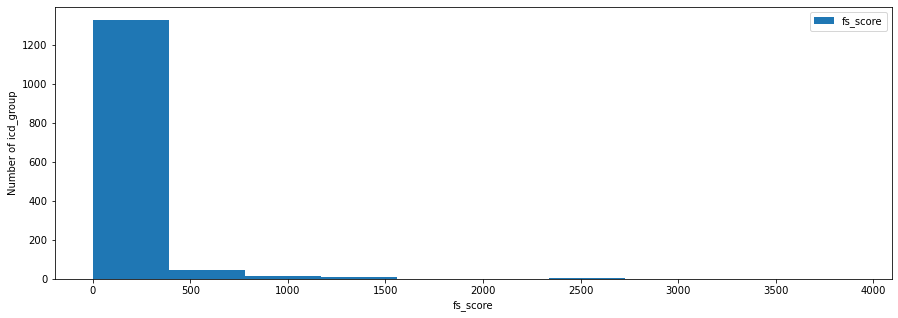

In [197]:
dict_icd_fs_chi2 = {}
for i in range(len(fs.scores_)):
	dict_icd_fs_chi2[cat_encoder.categories_[0][i]]= fs.scores_[i]

df1 = pd.DataFrame.from_dict(dict_icd_fs_chi2,orient = 'index',columns=['fs_score'])
df1['icd_group'] = df1.index

#df1.to_csv('icd_chi2fs.csv')
df1 = df1.dropna()
df1 = df1.sort_values(by='fs_score',ascending=False).reset_index(drop=True)

ax = df1.plot.hist(column=["fs_score"],figsize=(15,5))
ax.set_xlabel("fs_score")
ax.set_ylabel("Number of icd_group")

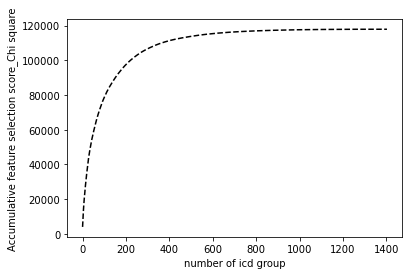

In [198]:
plt.plot(np.array(df1.fs_score).cumsum(), 'k--')
plt.ylabel('Accumulative feature selection score_Chi square')
plt.xlabel('number of icd group')
plt.show()

In [200]:
model = ExtraTreesClassifier(bootstrap = True,n_jobs = -1,random_state = 123, min_samples_leaf=100)
model.fit(X, Y_lst)

ExtraTreesClassifier(bootstrap=True, min_samples_leaf=100, n_jobs=-1,
                     random_state=123)

Text(0, 0.5, 'Number of icd_group')

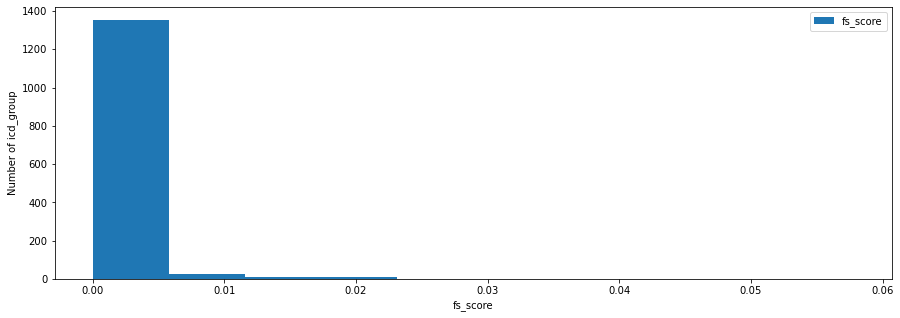

In [201]:
dict_icd_fs_extratree = {}
for i in range(len(model.feature_importances_)):
	dict_icd_fs_extratree[cat_encoder.categories_[0][i]]= model.feature_importances_[i]


df1 = pd.DataFrame.from_dict(dict_icd_fs_extratree,orient = 'index',columns=['fs_score'])
df1['icd_group'] = df1.index

#df1.to_csv('icd_extratreefs.csv')
df1 = df1.sort_values(by='fs_score',ascending=False).reset_index(drop=True)

ax = df1.plot.hist(column=["fs_score"],figsize=(15,5))
ax.set_xlabel("fs_score")
ax.set_ylabel("Number of icd_group")

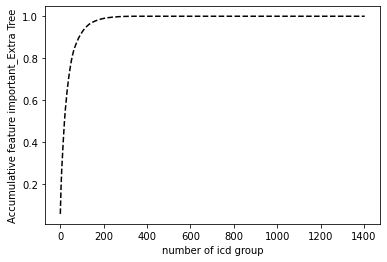

In [203]:
plt.plot(np.array(df1.fs_score).cumsum(), 'k--')
plt.ylabel('Accumulative feature important_Extra Tree')
plt.xlabel('number of icd group')
plt.show()

In [258]:
df1 = pd.DataFrame.from_dict(dict_icd_fs_chi2,orient = 'index',columns=['fs_score'])
df1['icd_group'] = df1.index
df1 = df1.dropna()

df2 = pd.DataFrame.from_dict(dict_icd_fs_extratree,orient = 'index',columns=['fs_score'])
df2['icd_group'] = df2.index

df_his_icd = pd.merge(df1,df2, how='inner', left_on = 'icd_group', right_on='icd_group')

df_his_icd = df_his_icd.sort_values(by = ['fs_score_x', 'fs_score_y'], ascending=False).reset_index(drop=True)


In [283]:
sum(df_his_icd[:198]['fs_score_y'])

0.9655970874488156

In [284]:
sum(df_his_icd[:198]['fs_score_x'])/sum(df_his_icd['fs_score_x'])

0.8239852522322626

In [285]:
his_icd_top198 = df_his_icd['icd_group'][:198]

In [286]:
his_icd_top198.to_csv('top198historical_icd.csv')

In [278]:
dict3 = {}

for i in range(len(data_2)):
    if i == 0:
        dict3[i] = []
    else:
        if (i > 0) & (type(data_2['fin_code_group'][i-1])== list):
            if (data_2['subject_id'][i] == data_2['subject_id'][i-1]):
                dict3[i] = []
                dict3[i].extend(list(data_2['fin_code_group'][i-1]))    
            else:
                dict3[i] = []
        else:
            dict3[i] = []
            
for i in range(len(dict3)):
    dict3[i] = str(','.join(dict3[i]))

In [287]:


df_pre_icd = pd.DataFrame.from_dict(dict3,orient = 'index',columns=['pre_icd_code'])

df_pre_icd_full = pd.merge(data_2,df_pre_icd,how = 'inner', left_index=True, right_index= True)

df_pre_icd_full.to_csv('previous_icd_code.csv')

df_pre_icd_full

,key,fin_code_group,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,pre_icd_code
0,10000032_33258284,"[K72, R18, 707, Z21]",10000032.0,22595853.0,33258284.0,2180-05-06 19:17:00,2180-05-06 23:30:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,
1,10000032_38112554,"[R18, 707, K74, Z21]",10000032.0,22841357.0,38112554.0,2180-06-26 15:54:00,2180-06-26 21:31:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"K72,R18,707,Z21"
2,10000032_32952584,"[I95, 707, Z21]",10000032.0,29079034.0,32952584.0,2180-07-22 16:24:00,2180-07-23 05:54:00,F,WHITE,AMBULANCE,HOME,HOME,"R18,707,K74,Z21"
3,10000032_39399961,"[R41, G93]",10000032.0,29079034.0,39399961.0,2180-07-23 05:54:00,2180-07-23 14:00:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"I95,707,Z21"
4,10000032_35968195,"[K74, R10, Z21]",10000032.0,25742920.0,35968195.0,2180-08-05 20:58:00,2180-08-06 01:44:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,"R41,G93"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
447546,19996061_32594978,"[S00, S10, W10]",NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,
447547,19997911_31052958,"[E87, I10]",NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,
447548,19997948_30726700,[R10],NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,
447549,19998485_32846388,"[S02, S06, V29, S27]",NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,


In [277]:
dict3

{0: '',
 1: 'K72,R18,707,Z21',
 2: 'R18,707,K74,Z21',
 3: 'I95,707,Z21',
 4: 'R41,G93',
 5: '',
 6: 'R53,G20',
 7: '',
 8: 'R22',
 9: 'K12',
 10: '',
 11: 'S02,S01,W17',
 12: '',
 13: 'R13',
 14: 'S09,S01,W22',
 15: '',
 16: '',
 17: '',
 18: 'R10',
 19: '',
 20: '',
 21: '',
 22: '',
 23: 'R42,E11,I10,E78',
 24: '',
 25: '',
 26: '',
 27: '',
 28: '',
 29: 'F32,R45,Z85',
 30: 'K76',
 31: 'R11,G93,R53,R60',
 32: 'M79,C34',
 33: '',
 34: '',
 35: 'I20,R06,I25,E10,I10',
 36: 'M79,E11,Z79,I10',
 37: 'I50,J18,E11,Z79,I10,E78',
 38: 'M79,I10,E11',
 39: 'I50,R07',
 40: 'I82,D64',
 41: 'D64,R06',
 42: 'I50,E11,N18,Z79',
 43: 'E11,Z79',
 44: 'I50',
 45: '',
 46: '',
 47: '',
 48: '',
 49: 'G44,R51,I10,N39',
 50: '',
 51: '',
 52: '',
 53: 'G93,R53,R50',
 54: '',
 55: '',
 56: 'R10',
 57: 'S90,V03',
 58: '',
 59: 'K56',
 60: 'I26',
 61: 'R10',
 62: '',
 63: '',
 64: '',
 65: '',
 66: '',
 67: '',
 68: '',
 69: '',
 70: '',
 71: '',
 72: '',
 73: 'R07,I10,J45',
 74: 'R07,I10',
 75: 'J44,J18',
 7

In [276]:
df_pre_icd_full['fin_code_group'][0][0]

'K72'

# Data overview 1

In [35]:
edstays_admit_1

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key,key_diag
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_33258284,10000032_33258284
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_38112554,10000032_38112554
2,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_35968195,10000032_35968195
3,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,HOME,10000032_32952584,10000032_32952584
4,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_39399961,10000032_39399961
...,...,...,...,...,...,...,...,...,...,...,...,...
427258,19999784,25715748.0,34149746,11/8/2119 9:15,11/8/2119 13:40,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_34149746,19999784_34149746
427259,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_35692999,19999784_35692999
427260,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,19999828_32917002,19999828_32917002
427261,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,ADMITTED,19999828_30712109,19999828_30712109


427.263 obs has diagnostic information

In [204]:
edstays_admit['DateTime_in'] = pd.to_datetime(edstays_admit['intime'], format='%d/%m/%Y %H:%M')
edstays_admit['DateTime_out'] = pd.to_datetime(edstays_admit['outtime'], format='%d/%m/%Y %H:%M')

In [205]:
edstays_admit['stay'] = edstays_admit['DateTime_out'] - edstays_admit['DateTime_in']

In [206]:
edstays_admit[(edstays_admit.DateTime_out<edstays_admit.DateTime_in) | (edstays_admit.DateTime_out==edstays_admit.DateTime_in)]

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key,DateTime_in,DateTime_out,stay
3565,10086553,NaN,31130161,17/6/2131 23:58,17/6/2131 23:34,F,WHITE,WALK IN,HOME,HOME,10086553_31130161,2131-06-17 23:58:00,2131-06-17 23:34:00,-1 days +23:36:00
62062,11458820,NaN,37308943,14/5/2135 21:59,14/5/2135 4:10,F,OTHER,WALK IN,HOME,HOME,11458820_37308943,2135-05-14 21:59:00,2135-05-14 04:10:00,-1 days +06:11:00
147418,13453976,NaN,39783953,8/10/2159 23:58,8/10/2159 20:09,F,WHITE,WALK IN,HOME,HOME,13453976_39783953,2159-10-08 23:58:00,2159-10-08 20:09:00,-1 days +20:11:00
169927,13987916,NaN,31098738,27/1/2115 23:13,27/1/2115 0:47,M,WHITE,AMBULANCE,HOME,HOME,13987916_31098738,2115-01-27 23:13:00,2115-01-27 00:47:00,-1 days +01:34:00
364209,18507700,NaN,30410555,11/5/2179 23:38,11/5/2179 4:14,M,WHITE,AMBULANCE,HOME,HOME,18507700_30410555,2179-05-11 23:38:00,2179-05-11 04:14:00,-1 days +04:36:00
395702,19238062,NaN,37548718,20/5/2136 19:41,20/5/2136 19:41,M,OTHER,WALK IN,HOME,HOME,19238062_37548718,2136-05-20 19:41:00,2136-05-20 19:41:00,0 days 00:00:00


<AxesSubplot:xlabel='gender'>

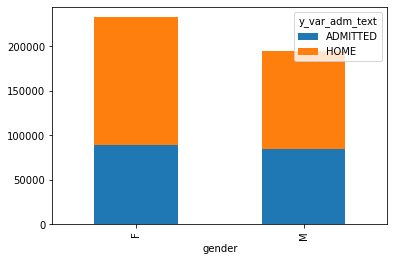

In [207]:
edstays_admit.groupby(['gender', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True)

In [208]:
edstays_admit['race'].value_counts()

WHITE                                        231287
BLACK/AFRICAN AMERICAN                        77018
OTHER                                         20972
HISPANIC/LATINO - PUERTO RICAN                14167
WHITE - OTHER EUROPEAN                         9190
HISPANIC/LATINO - DOMINICAN                    8448
BLACK/CAPE VERDEAN                             7796
ASIAN                                          7532
ASIAN - CHINESE                                7476
WHITE - RUSSIAN                                6213
UNKNOWN                                        5189
BLACK/AFRICAN                                  4903
BLACK/CARIBBEAN ISLAND                         3710
HISPANIC OR LATINO                             3147
HISPANIC/LATINO - GUATEMALAN                   2391
ASIAN - ASIAN INDIAN                           1616
ASIAN - SOUTH EAST ASIAN                       1576
HISPANIC/LATINO - SALVADORAN                   1521
WHITE - BRAZILIAN                              1508
PORTUGUESE  

In [209]:
edstays_admit.loc[edstays_admit['race'].str.contains('WHITE'), 'race_color'] = 'WHITE'
edstays_admit.loc[edstays_admit['race'].str.contains('BLACK'), 'race_color'] = 'BLACK'
edstays_admit.loc[edstays_admit['race'].str.contains('ASIAN'), 'race_color'] = 'ASIAN'
edstays_admit.loc[edstays_admit['race'].str.contains('LATINO'), 'race_color'] = 'HISPANIC/LATINO'
edstays_admit.loc[edstays_admit['race'].str.contains('HISPANIC'), 'race_color'] = 'HISPANIC/LATINO'
edstays_admit.loc[edstays_admit['race_color'].isna(), 'race_color'] = 'OTHER'

In [210]:
edstays_admit.groupby(['race_color', 'y_var_adm_text']).size().unstack()

y_var_adm_text,ADMITTED,HOME
race_color,,
ASIAN,6306,12722
BLACK,29162,64265
HISPANIC/LATINO,9434,25491
OTHER,13263,18099
WHITE,115574,133968


[Text(0, 0, '0.67'),
 Text(0, 0, '0.69'),
 Text(0, 0, '0.73'),
 Text(0, 0, '0.58'),
 Text(0, 0, '0.54')]

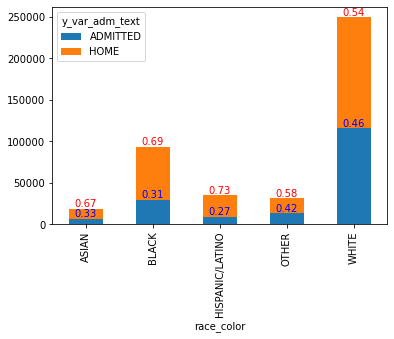

In [211]:
ax = edstays_admit.groupby(['race_color', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True)
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],color = "red")

[Text(20, 0, '0.43'),
 Text(20, 0, '0.06'),
 Text(20, 0, '0.64'),
 Text(20, 0, '0.15'),
 Text(20, 0, '0.71')]

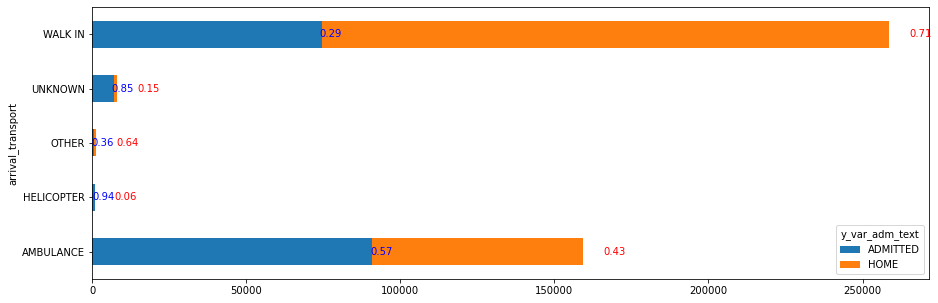

In [212]:
ax = edstays_admit.groupby(['arrival_transport', 'y_var_adm_text']).size().unstack().plot(kind='barh', stacked=True, rot = False, figsize = (15,5))
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,padding=-2,rotation=0, color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],padding=20, rotation=0, color = "red")

In [213]:
edstays_admit_1 = edstays_admit.sort_values(by = ['subject_id','DateTime_in'], ascending=True).reset_index(drop=True)

In [214]:
edstays_admit

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key,DateTime_in,DateTime_out,stay,race_color
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,0 days 04:13:00,WHITE
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,0 days 05:37:00,WHITE
2,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,0 days 04:46:00,WHITE
3,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,HOME,10000032_32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,0 days 13:30:00,WHITE
4,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,0 days 08:06:00,WHITE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428279,19999784,25715748.0,34149746,11/8/2119 9:15,11/8/2119 13:40,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,0 days 04:25:00,BLACK
428280,19999784,26194817.0,35692999,18/6/2119 14:21,18/6/2119 21:09,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_35692999,2119-06-18 14:21:00,2119-06-18 21:09:00,0 days 06:48:00,BLACK
428281,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,19999828_32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,0 days 09:01:00,WHITE
428282,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,ADMITTED,19999828_30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1 days 00:16:00,WHITE


In [216]:
edstay_hist = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_hist[i] = 'NO HISTORY'
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]:
            edstay_hist[i] = edstays_admit_1['y_var_adm_text'][i-1]
        else:
            edstay_hist[i] = 'NO HISTORY'

In [217]:
edstay_laststay = {}
for i in range(len(edstays_admit_1)):
    if i == 0:
        edstay_laststay[i] = np.timedelta64(0, 'D')
    else:
        if edstays_admit_1['subject_id'][i] == edstays_admit_1['subject_id'][i-1]:
            edstay_laststay[i] = edstays_admit_1['stay'][i-1]+edstay_laststay[i-1]
        else:
            edstay_laststay[i] = np.timedelta64(0, 'D')

In [218]:
df1 = pd.DataFrame.from_dict(edstay_hist,orient='index')
df1.columns = ['historical_stay_status']

In [219]:
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 

In [220]:
df1 = pd.DataFrame.from_dict(edstay_laststay,orient='index')
df1.columns = ['historical_stay_length']
edstays_admit_1 = pd.merge(edstays_admit_1,df1,how = 'left',left_index=True,right_index=True) 

[Text(0, 0, '0.35'), Text(0, 0, '0.73'), Text(0, 0, '0.62')]

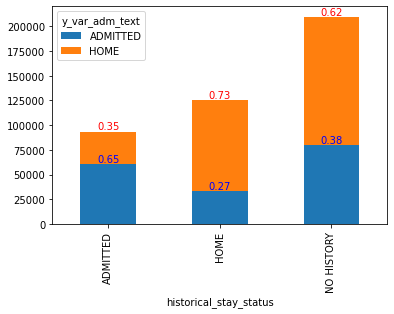

In [221]:
ax = edstays_admit_1.groupby(['historical_stay_status', 'y_var_adm_text']).size().unstack().plot(kind='bar', stacked=True)
percent = []
for i in range(len(ax.containers[0])):
    percent.extend([round( ax.containers[0].datavalues[i]/(ax.containers[0].datavalues[i]+ax.containers[1].datavalues[i]),2)])

ax.bar_label(ax.containers[0], labels=percent,color = "blue")
ax.bar_label(ax.containers[1], labels=[round((1 - i),2) for i in percent ],color = "red")

In [222]:
edstays_admit_1['historical_stay_length_in_day'] = edstays_admit_1['historical_stay_length']/(np.timedelta64(1, 'D'))



In [223]:
edstays_admit_1

,subject_id,hadm_id,stay_id,intime,outtime,gender,race,arrival_transport,disposition,y_var_adm_text,key,DateTime_in,DateTime_out,stay,race_color,historical_stay_status,historical_stay_length,historical_stay_length_in_day
0,10000032,22595853.0,33258284,6/5/2180 19:17,6/5/2180 23:30,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_33258284,2180-05-06 19:17:00,2180-05-06 23:30:00,0 days 04:13:00,WHITE,NO HISTORY,0 days 00:00:00,0.000000
1,10000032,22841357.0,38112554,26/6/2180 15:54,26/6/2180 21:31,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_38112554,2180-06-26 15:54:00,2180-06-26 21:31:00,0 days 05:37:00,WHITE,ADMITTED,0 days 04:13:00,0.175694
2,10000032,29079034.0,32952584,22/7/2180 16:24,23/7/2180 5:54,F,WHITE,AMBULANCE,HOME,HOME,10000032_32952584,2180-07-22 16:24:00,2180-07-23 05:54:00,0 days 13:30:00,WHITE,ADMITTED,0 days 09:50:00,0.409722
3,10000032,29079034.0,39399961,23/7/2180 5:54,23/7/2180 14:00,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_39399961,2180-07-23 05:54:00,2180-07-23 14:00:00,0 days 08:06:00,WHITE,HOME,0 days 23:20:00,0.972222
4,10000032,25742920.0,35968195,5/8/2180 20:58,6/8/2180 1:44,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,10000032_35968195,2180-08-05 20:58:00,2180-08-06 01:44:00,0 days 04:46:00,WHITE,ADMITTED,1 days 07:26:00,1.309722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428279,19999784,24935234.0,37972930,9/7/2119 17:38,10/7/2119 0:04,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_37972930,2119-07-09 17:38:00,2119-07-10 00:04:00,0 days 06:26:00,BLACK,ADMITTED,0 days 06:48:00,0.283333
428280,19999784,25715748.0,34149746,11/8/2119 9:15,11/8/2119 13:40,M,BLACK/AFRICAN AMERICAN,WALK IN,ADMITTED,ADMITTED,19999784_34149746,2119-08-11 09:15:00,2119-08-11 13:40:00,0 days 04:25:00,BLACK,ADMITTED,0 days 13:14:00,0.551389
428281,19999828,29734428.0,30712109,17/7/2147 17:18,18/7/2147 17:34,F,WHITE,WALK IN,ADMITTED,ADMITTED,19999828_30712109,2147-07-17 17:18:00,2147-07-18 17:34:00,1 days 00:16:00,WHITE,NO HISTORY,0 days 00:00:00,0.000000
428282,19999828,25744818.0,32917002,8/1/2149 9:11,8/1/2149 18:12,F,WHITE,AMBULANCE,ADMITTED,ADMITTED,19999828_32917002,2149-01-08 09:11:00,2149-01-08 18:12:00,0 days 09:01:00,WHITE,ADMITTED,1 days 00:16:00,1.011111


<AxesSubplot:xlabel='y_var_adm_text', ylabel='historical_stay_length_in_day'>

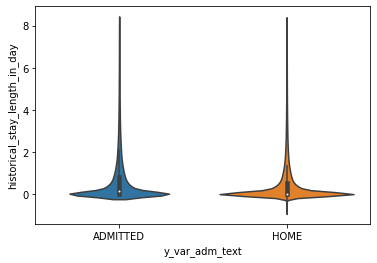

In [224]:
df = edstays_admit_1['historical_stay_length_in_day']
df = df[(np.abs(stats.zscore(df)) < 2)]
df = pd.merge(df,edstays_admit_1['y_var_adm_text'],how = 'left',left_index=True,right_index=True)
sns.violinplot(x = 'y_var_adm_text', y = 'historical_stay_length_in_day', data = df)

## 1.3 Triage table

In [225]:
triage = look_n_load('raw/triage.csv')


Shape: (447712, 11)

Columns: ['subject_id', 'stay_id', 'temperature', 'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 'chiefcomplaint']

Missing proportions:
 subject_id        0.000000
stay_id           0.000000
temperature       0.054935
heartrate         0.040111
resprate          0.047743
o2sat             0.048355
sbp               0.042941
dbp               0.044823
pain              0.030415
acuity            0.016368
chiefcomplaint    0.000051
dtype: float64


In [226]:
t_count = pd.DataFrame(triage.groupby(['subject_id', 'stay_id'])['stay_id'].count()) 

t_count[t_count['stay_id']>1]

,,stay_id
subject_id,stay_id,


each person per stay id only have 1 triage record

In [227]:
triage_1 = pd.merge(edstays_admit_1[['subject_id', 'stay_id','y_var_adm_text']],triage,how = 'left',on=['subject_id', 'stay_id'])


In [228]:
triage_1

,subject_id,stay_id,y_var_adm_text,temperature,heartrate,resprate,o2sat,sbp,dbp,pain,acuity,chiefcomplaint
0,10000032,33258284,ADMITTED,98.4,70.0,16.0,97.0,106.0,63.0,0,3.0,"Abd pain, Abdominal distention"
1,10000032,38112554,ADMITTED,98.9,88.0,18.0,97.0,116.0,88.0,10,3.0,Abdominal distention
2,10000032,32952584,HOME,97.8,87.0,14.0,97.0,71.0,43.0,7,2.0,Hypotension
3,10000032,39399961,ADMITTED,98.7,77.0,16.0,98.0,96.0,50.0,13,2.0,"Abdominal distention, Abd pain, LETHAGIC"
4,10000032,35968195,ADMITTED,99.4,105.0,18.0,96.0,106.0,57.0,10,3.0,"n/v/d, Abd pain"
...,...,...,...,...,...,...,...,...,...,...,...,...
428279,19999784,37972930,ADMITTED,98.0,91.0,16.0,99.0,148.0,90.0,5,2.0,Abnormal MRI
428280,19999784,34149746,ADMITTED,98.8,92.0,18.0,100.0,122.0,77.0,0,3.0,Wound eval
428281,19999828,30712109,ADMITTED,98.1,83.0,18.0,100.0,107.0,75.0,8,2.0,"Abd pain, Wound eval"
428282,19999828,32917002,ADMITTED,96.6,112.0,18.0,100.0,110.0,82.0,4,2.0,"Abd pain, Wound eval"


array([[<AxesSubplot:title={'center':'temperature'}>,
        <AxesSubplot:title={'center':'heartrate'}>,
        <AxesSubplot:title={'center':'resprate'}>],
       [<AxesSubplot:title={'center':'o2sat'}>,
        <AxesSubplot:title={'center':'sbp'}>,
        <AxesSubplot:title={'center':'dbp'}>],
       [<AxesSubplot:title={'center':'acuity'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

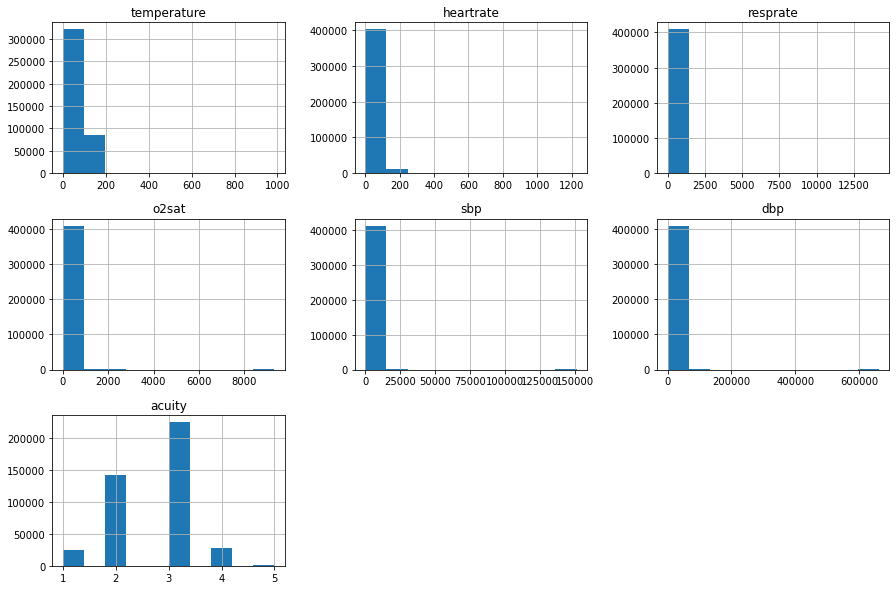

In [229]:
triage_1[['temperature','heartrate','resprate','o2sat','sbp','dbp','pain','acuity']].hist(figsize=[15,10])

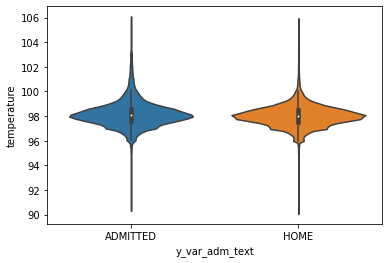

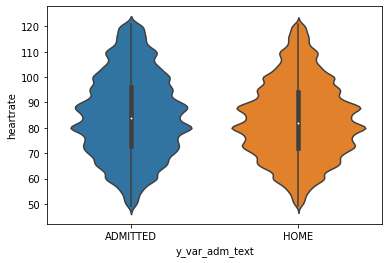

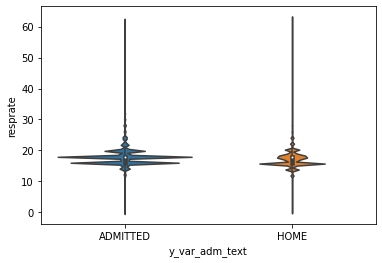

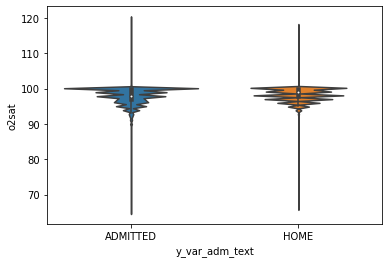

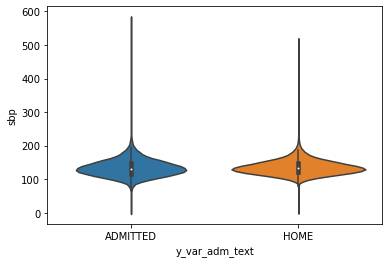

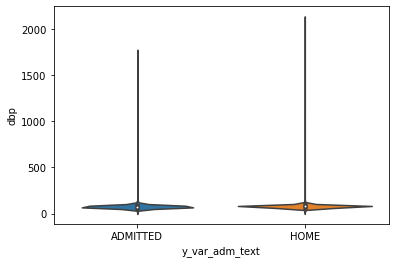

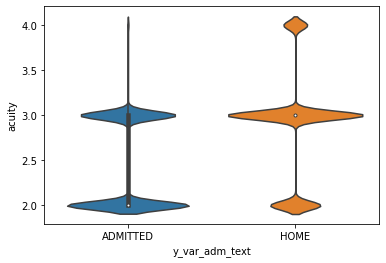

In [230]:
lst_col = ['temperature','heartrate','resprate','o2sat','sbp','dbp','acuity']
for i in lst_col:
    plt.figure()
    df = triage_1[[i]].dropna()
    df = df[(np.abs(stats.zscore(df)) < 2)]
    df = pd.merge(df,triage_1['y_var_adm_text'],how = 'left',left_index=True,right_index=True)
    sns.violinplot(x = 'y_var_adm_text', y = i, data = df)

In [231]:
triage_1['y_var'] = 0
triage_1.loc[triage_1['y_var_adm_text'] == 'ADMITTED','y_var'] = 1

In [232]:
triage_1.drop(['subject_id','stay_id'],axis = 1).corr()

,temperature,heartrate,resprate,o2sat,sbp,dbp,acuity,y_var
temperature,1.000000,0.049679,0.001734,-0.000869,0.025878,-0.000109,-0.003087,0.016095
heartrate,0.049679,1.000000,0.016282,-0.009000,0.000226,0.001483,-0.121416,0.074012
resprate,0.001734,0.016282,1.000000,-0.001180,0.000296,-0.000057,-0.018400,0.017318
o2sat,-0.000869,-0.009000,-0.001180,1.000000,0.000440,0.000213,0.024255,-0.025018
sbp,0.025878,0.000226,0.000296,0.000440,1.000000,0.004016,0.001692,-0.003760
dbp,-0.000109,0.001483,-0.000057,0.000213,0.004016,1.000000,0.000993,-0.002265
acuity,-0.003087,-0.121416,-0.018400,0.024255,0.001692,0.000993,1.000000,-0.377422
y_var,0.016095,0.074012,0.017318,-0.025018,-0.003760,-0.002265,-0.377422,1.000000


<AxesSubplot:>

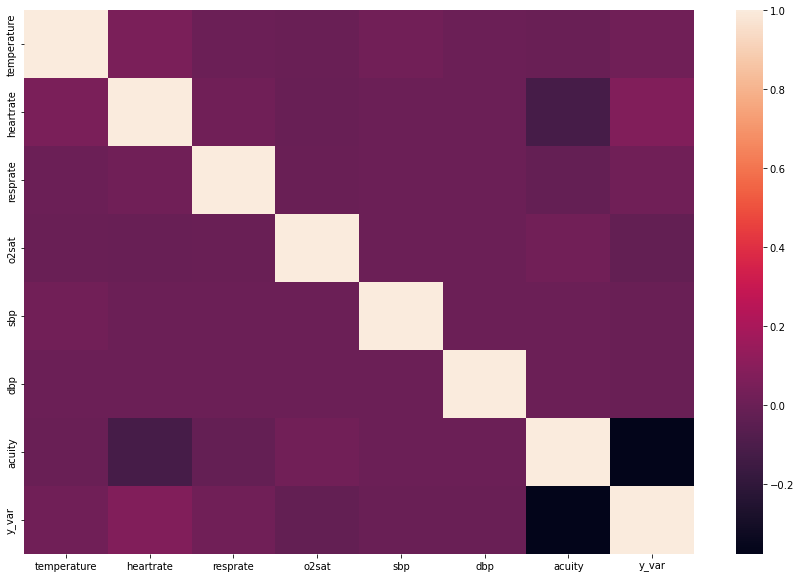

In [233]:
plt.figure(figsize=(15, 10))

sns.heatmap(triage_1.drop(['subject_id','stay_id'],axis = 1).corr())


In [239]:
triage_1['chiefcomplaint']

0                   Abd pain, Abdominal distention
1                             Abdominal distention
2                                      Hypotension
3         Abdominal distention, Abd pain, LETHAGIC
4                                  n/v/d, Abd pain
                            ...                   
428279                                Abnormal MRI
428280                                  Wound eval
428281                        Abd pain, Wound eval
428282                        Abd pain, Wound eval
428283                                  HEAD BLEED
Name: chiefcomplaint, Length: 428284, dtype: object